# Generative Adversarial Networks

In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [2]:
transform = transforms.ToTensor()
train_data = MNIST(root='data', train=True, download=True, transform=transform)

In [3]:
batch_size = 64
num_workers = 0
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

In [4]:
images, labels = iter(train_loader).next()
images = images.numpy()

In [5]:
print('Maximum intensity value:', np.max(images[0].squeeze()))
print('Minimum intensity value:', np.min(images[0].squeeze()))

Maximum intensity value: 1.0
Minimum intensity value: 0.0


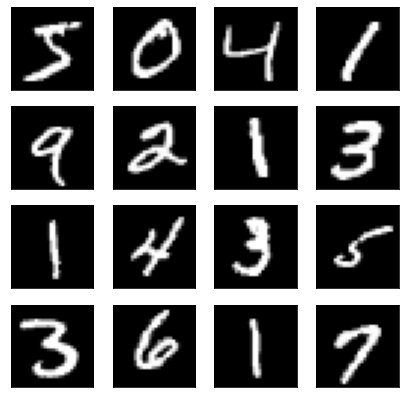

In [6]:
fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), images[:16]):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='gray')

In [7]:
class Discriminator(nn.Module):

    def __init__(self, input_size=784, hidden=(128, 64, 32), output_size=1):
        super(Discriminator, self).__init__()

        # Hidden layers
        self.fc1 = nn.Linear(input_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])

        # Output layer
        self.fc4 = nn.Linear(hidden[2], output_size)

        # Dropout layer
        self.dropout = nn.Dropout(.3)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.leaky_relu(self.fc1(x)) 
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        out = self.fc4(x)
        return out
  

In [8]:
class Generator(nn.Module):

    def __init__(self, input_size=100, hidden=(32, 64, 128), output_size=784):
        super(Generator, self).__init__()

        # Hidden layers
        self.fc1 = nn.Linear(input_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])

        # Output layer
        self.fc4 = nn.Linear(hidden[2], output_size)

        # Dropout layer
        self.dropout = nn.Dropout(.3)

        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        out = torch.tanh(self.fc4(x))
        return out

In [9]:
dis = Discriminator(784, (128, 64, 32),  1)
gen = Generator(100, (32, 64, 128), 784)

In [10]:
def real_loss(out, smooth=False):
    """
    Calculate Binary Cross Entropy Loss from logit

    Label smoothing can be done to have a numerically stable loss function
    """
    batch_size = out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(out.squeeze(), labels)
    return loss

def fake_loss(out):
    batch_size = out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(out.squeeze(), labels)
    return loss

In [11]:
# Optimizers
lr = 0.002
d_opt = optim.Adam(dis.parameters(), lr)
g_opt = optim.Adam(gen.parameters(), lr)

Epoch [    1/  200] | d_loss: 0.9163 | g_loss: 3.3172


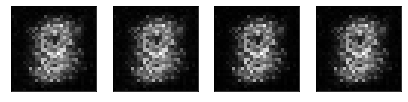

Epoch [   21/  200] | d_loss: 1.0299 | g_loss: 1.1814


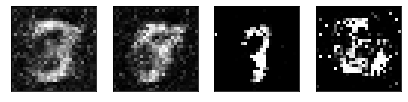

Epoch [   41/  200] | d_loss: 1.1212 | g_loss: 1.3699


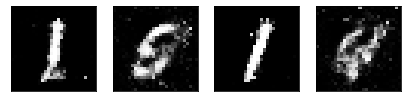

Epoch [   61/  200] | d_loss: 1.1543 | g_loss: 1.5251


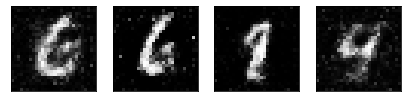

Epoch [   81/  200] | d_loss: 0.9789 | g_loss: 1.0029


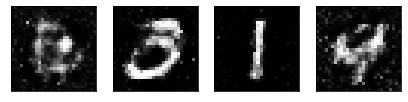

Epoch [  101/  200] | d_loss: 0.9238 | g_loss: 1.2087


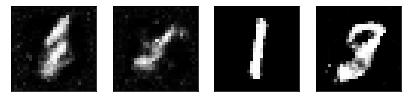

Epoch [  121/  200] | d_loss: 1.2351 | g_loss: 1.0754


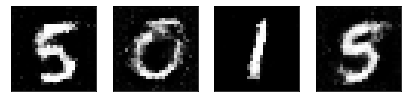

Epoch [  141/  200] | d_loss: 1.1613 | g_loss: 1.0946


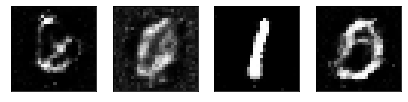

Epoch [  161/  200] | d_loss: 0.9397 | g_loss: 0.9384


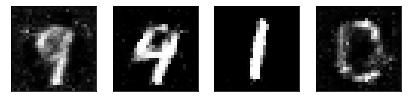

Epoch [  181/  200] | d_loss: 1.1660 | g_loss: 1.0563


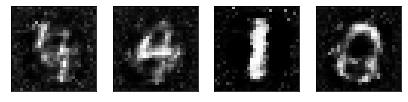

In [12]:
EPOCHS = 200

gen_out = []
losses = []

sample_size = 4
fixed_z = np.random.uniform(-1, 1, size=(sample_size, 100))
fixed_z = torch.from_numpy(fixed_z).float()

dis.train()
gen.train()
for epoch in range(EPOCHS):
    for real_images, labels in train_loader: 
        batch_size = real_images.size(0)
        
        real_images = real_images*2 - 1  # Very important
      
        # Train discriminator
        d_opt.zero_grad()

        d_real = dis(real_images)
        d_real_loss = real_loss(d_real, smooth=True)

        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, 100))
            z = torch.from_numpy(z).float()
            fake_images = gen(z)
        d_fake = dis(fake_images)
        d_fake_loss = fake_loss(d_fake)

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_opt.step()
        
        # Train generator
        g_opt.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, 100))
        z = torch.from_numpy(z).float()
        fake_images = gen(z)

        d_fake = dis(fake_images)
        g_loss = real_loss(d_fake) 
      
        g_loss.backward()
        g_opt.step()

    if epoch % 20 == 0:
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, EPOCHS, d_loss.item(), g_loss.item()))
    
        gen.eval()
        samples = gen(fixed_z)
        gen.train()

        _, axes = plt.subplots(figsize=(7,7), nrows=1, ncols=4, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(), samples):
            img = img.detach()
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((28,28)), cmap='gray')
        plt.show()    

    losses.append((d_loss.item(), g_loss.item()))

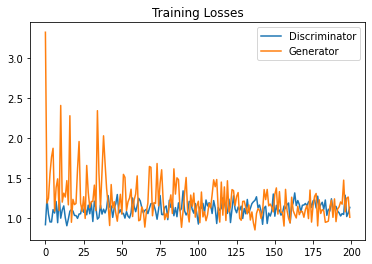

In [13]:
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

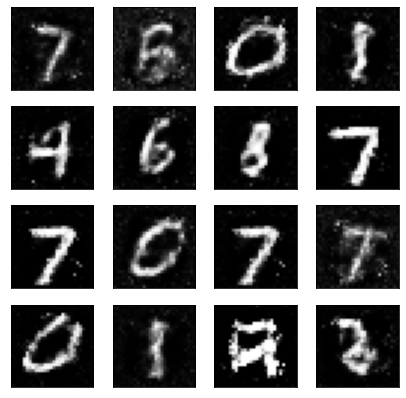

In [14]:
sample_size = 16
z = np.random.uniform(-1, 1, size=(sample_size, 100))
z = torch.from_numpy(z).float()

gen.eval()
generated_images = gen(z)

fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), generated_images):
    img = img.detach()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='gray')